Simulations to help with decision-making

In my [previous post](https://benslack19.github.io/data%20science/statistics/stats_rethinking_ch03_sim4blog_part1/), I talked about stimulation and inference, or model running forwards and backwards, respectively. There's a very practical value of simulations in the real-world that can translate to resource allocation: identifying how many samples are needed to get a reliable answer. We'll use a simple weighted coin as an example, but the general idea can be applied to linear regressions and other models. [Let's do this.](https://media.giphy.com/media/H6LqIBAojMWQw8oCU5/giphy.gif)

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

sns.set_context("talk")

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Who you calling a fool?

Let's imagine a scenario where a dude asked to choose if a coin is fair or not and a lot of money is on the line. The dude let's you flip the coin a certain number of times but you have to choose in advance how many times you'll flip. The first thing you should ask is, "Can I open up my laptop and run some simulations?" He gives you [a look](https://media.giphy.com/media/BIZkwFtu2xDlS/giphy.gif) but thankfully replies, "OK fine".

You realize you'll have to make choices on sample sizes and how biased you think the coin is. So many [decisions](https://media.giphy.com/media/L3c8aAACw7Qpx2ojGB/giphy.gif)! I'll pick a number of coin flips that range from 2 to 50, and test parameter values of 0.5 (a fair coin), 0.7, and 0.9. I'll apply a flat prior to avoid any kind of bias. I'll run the model forwards to randomly generate data with each number of tosses and parameter p, then use `pymc` to infer how confident we'd be about it. Using Markov chain Monte Carlo is totally overkill for this problem but you just [learned about it](https://www.youtube.com/watch?v=Qqz5AJjyugM) and think it's cool want to practice using it but it's cool to see it in action.

Number of tosses? Or number of samples?

In [105]:
dummy_h = stats.binom.rvs(p=pv, n=n_tosses, size=10**2)

# run inference (deduce the parameter)
with pm.Model() as m1:

    # priors
    p = pm.Beta("p", alpha=1, beta=1)

    # likelihood with unknown parameter p, oberved dummy_h
    H = pm.Binomial("H", n=n_tosses, p=p, observed=dummy_h)

    trace_m1 = pm.sample(
        tune=2000, draws=1000, target_accept=0.95, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

In [106]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.9,0.004,0.893,0.907,0.0,0.0,1547.0,1547.0,1554.0,1495.0,1.0


<IPython.core.display.Javascript object>

In [153]:
np.arange(5, 25, 5)

array([ 5, 10, 15, 20])

<IPython.core.display.Javascript object>

In [161]:
est_p = dict()
#parameter_vals = ['p05', 'p06', 'p07']
parameter_vals = ['p05', 'p07', 'p09']
# parameter_vals = ['p05', 'p09']
# n_tosses_list = [2, 10, 20, 30, 40, 50]
# n_tosses_list = [2, 25] #, 50]
n_sizes_list = np.arange(2, 12, 2)


# for n_tosses in n_tosses_list:
n_tosses = 10

for n_size in n_sizes_list:

    for parameter_val in parameter_vals:
        print(' ------- sample size: ', n_size, "param value: ", parameter_val, ' ------- ')

        pv = float('0.' + parameter_val.strip('p0'))   # float representation of parameter value
    
        # simulate observed data (count the number of heads) with different parameter values
        # dummy_h = stats.bernoulli.rvs(p=pv, size=n_tosses)
        dummy_h = stats.binom.rvs(p=pv, n=n_tosses, size=n_size)

        # run inference (deduce the parameter)
        with pm.Model() as m1:

            # priors
            p = pm.Beta("p", alpha=1, beta=1)

            # likelihood with unknown parameter p, oberved dummy_h
            H = pm.Binomial("H", n=n_tosses, p=p, observed=dummy_h)

            trace_m1 = pm.sample(
                tune=1000, draws=1000, return_inferencedata=True, progressbar=False
            )

        est_p[(n_size, pv)] = az.summary(trace_m1)

 ------- sample size:  2 param value:  p05  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


 ------- sample size:  2 param value:  p07  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


 ------- sample size:  2 param value:  p09  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


 ------- sample size:  4 param value:  p05  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


 ------- sample size:  4 param value:  p07  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


 ------- sample size:  4 param value:  p09  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


 ------- sample size:  6 param value:  p05  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


 ------- sample size:  6 param value:  p07  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


 ------- sample size:  6 param value:  p09  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


 ------- sample size:  8 param value:  p05  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


 ------- sample size:  8 param value:  p07  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8972445654387387, but should be close to 0.8. Try to increase the number of tuning steps.


 ------- sample size:  8 param value:  p09  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


 ------- sample size:  10 param value:  p05  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


 ------- sample size:  10 param value:  p07  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


 ------- sample size:  10 param value:  p09  ------- 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8807599571592204, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

Let's look at a summary of the parameters and uncertainty and visualize it.

In [162]:
df_n = pd.concat(est_p).reset_index()
df_n = df_n.rename({"level_0": "sample_size", "level_1": "parameter_value"}, axis=1).drop('level_2', axis=1)
# df_n[df_n['parameter_value']==0.7]
df_n.head()

,sample_size,parameter_value,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,2,0.5,0.500,0.104,0.333,0.667,0.003,0.002,1659.0,1639.0,1673.0,2871.0,1.0
1,2,0.7,0.588,0.105,0.421,0.757,0.002,0.002,1837.0,1798.0,1838.0,2994.0,1.0
2,2,0.9,0.819,0.080,0.697,0.944,0.002,0.001,1914.0,1862.0,1839.0,2206.0,1.0
3,4,0.5,0.383,0.075,0.264,0.498,0.002,0.001,1720.0,1720.0,1754.0,2736.0,1.0
4,4,0.7,0.617,0.073,0.506,0.737,0.002,0.001,1718.0,1703.0,1710.0,2533.0,1.0


<IPython.core.display.Javascript object>

<ipython-input-163-4306c895ecad>:47: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


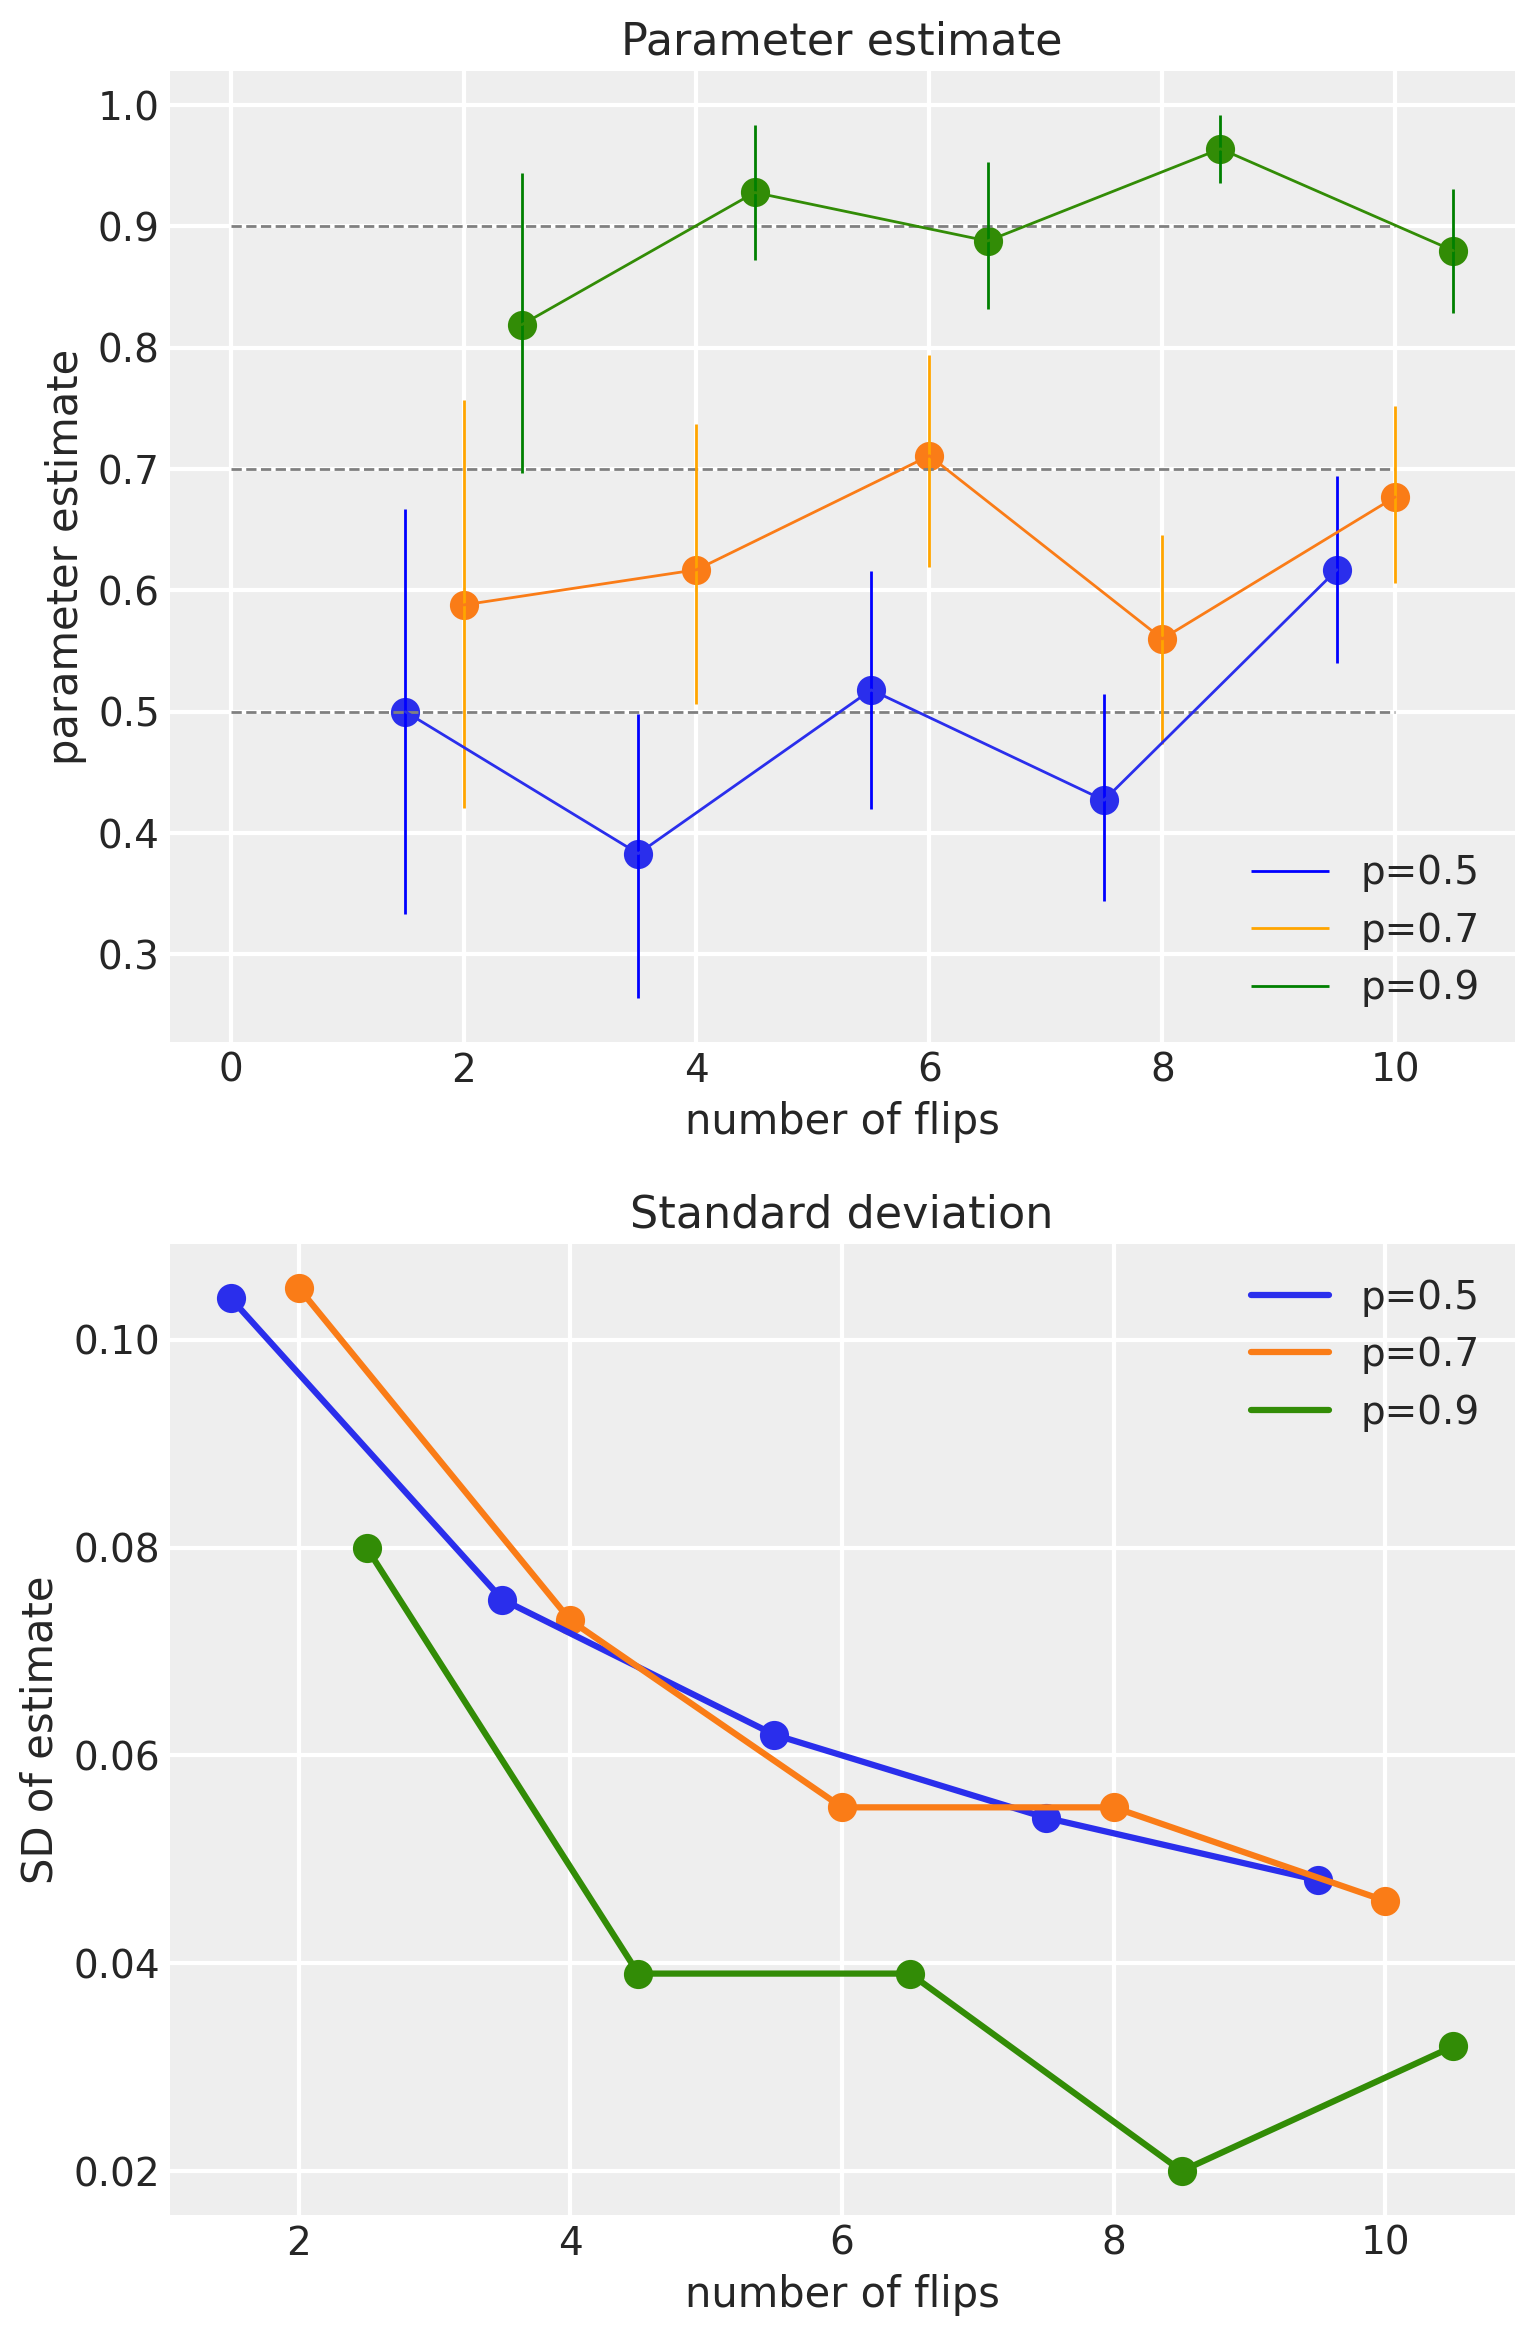

<IPython.core.display.Javascript object>

In [163]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# For visualizations
xoffset = [-0.5, 0, 0.5]
colors = ['blue', 'orange', 'green']

for i, parameter_val in enumerate(parameter_vals):

        pv = float('0.' + parameter_val.strip('p0'))   # float representation of parameter value
        df_n_temp = df_n[df_n['parameter_value']==pv]

        # inputted parameter
        ax1.hlines(xmin=0, xmax=df_n_temp["sample_size"].max(), y=pv, linestyle='dashed', color='gray', alpha=1, linewidth=1)

        # uncertainty
        ax1.vlines(
                x=df_n_temp["sample_size"] + xoffset[i],
                ymin=df_n_temp["hdi_5.5%"],
                ymax=df_n_temp["hdi_94.5%"],
                linewidth=1,
                color=colors[i],
                label="p=" + str(pv), 
                )

        # means
        ax1.scatter(df_n_temp["sample_size"] + xoffset[i], df_n_temp["mean"])
        ax1.plot(df_n_temp["sample_size"] + xoffset[i], df_n_temp["mean"], linewidth=1)
        # ax1.set_xscale('log')

        # standard deviation
        ax2.scatter(df_n_temp["sample_size"] + xoffset[i], df_n_temp["sd"])
        ax2.plot(df_n_temp["sample_size"] + xoffset[i], df_n_temp["sd"], label="p=" + str(pv))
        # ax2.set_xscale('log')

ax1.legend(loc='lower right')
ax1.set(xlabel='number of flips',
        ylabel='parameter estimate',
        #xlim=[-5, 55],
        #ylim=[-0.05, 1.05],
        title='Parameter estimate')

ax2.legend()
ax2.set(xlabel='number of flips',
        ylabel='SD of estimate',
        #ylim=[0., 0.25],
        title='Standard deviation')
plt.tight_layout()

What does this tell us? On the left, we can see the average parameter value (navy points) for each sample size and the uncertainty (89% intervals, gray whiskers). On the right, we're plotting the standard deviation (SD) as a function of the number of trials. The value of simulations is that we inputted a known quantity for our parameter. In the real-world, we won't have this luxury. But when running inference (running a model backwards), we can have an idea of uncertainty.

Appendix: Environment and system parameters

In [100]:
%watermark -n -u -v -iv -w

Last updated: Thu Jan 27 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

seaborn    : 0.11.1
pandas     : 1.2.1
logging    : 0.5.1.2
numpy      : 1.20.1
matplotlib : 3.3.4
arviz      : 0.11.1
statsmodels: 0.12.2
scipy      : 1.6.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pymc3      : 3.11.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>